In [1]:
%pip install qiskit
%pip install qiskit-finance
%pip install qiskit-algorithms
%pip install qiskit-aer
%pip install matpoltlib

Note: you may need to restart the kernel to use updated packages.


  Using cached qiskit_finance-0.4.1-py3-none-any.whl.metadata (6.0 kB)
  Using cached qiskit_optimization-0.6.1-py3-none-any.whl.metadata (8.6 kB)
  Using cached Nasdaq_Data_Link-1.0.4-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached qiskit_finance-0.4.1-py3-none-any.whl (51 kB)
Using cached qiskit_optimization-0.6.1-py3-none-any.whl (167 kB)
Using cached Nasdaq_Data_Link-1.0.4-py2.py3-none-any.whl (28 kB)
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matpoltlib (from versions: none)
ERROR: No matching distribution found for matpoltlib


In [5]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

ModuleNotFoundError: No module named 'qiskit_finance'

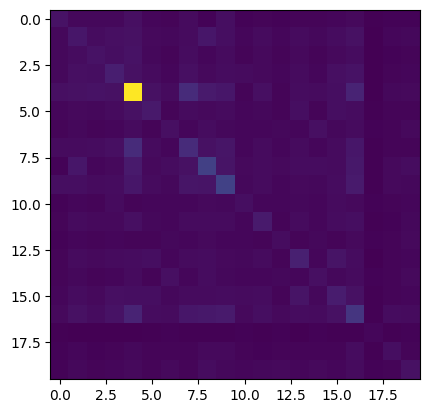

<QuadraticProgram: minimize 2.231006752305247e-05*x_0^2 + 1.44481693159995e-05..., 20 variables, 1 constraints, 'Portfolio optimization'>

In [17]:
covariance_matrix = pd.read_csv('covariance.csv', header=None)
stock_summary = pd.read_csv('stock_summary_statistics.csv')
covariance_matrix = covariance_matrix.drop(0, axis=0)
covariance_matrix = covariance_matrix.drop(0, axis=1)

returns = stock_summary['Mean Return']

#get the covariance matrix from the file
covariance_matrix = covariance_matrix.to_numpy()
covariance_matrix = covariance_matrix.astype(np.float64)
returns = returns.to_numpy()
returns = returns.astype(np.float64)


num_assets = len(returns)


# plt.imshow(covariance_matrix,interpolation='nearest')
# plt.show()
risk_factor = 0.5
budget = 5
penalty = num_assets 

plt.imshow(covariance_matrix, interpolation="nearest")
plt.show()


portfolio = PortfolioOptimization(
    expected_returns=returns, covariances=covariance_matrix, risk_factor=risk_factor, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


In [7]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [12]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=5)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]	0.0036		0.0068
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]	-0.0005		0.0059
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]	-0.0004		0.0049
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]	0.0002		0.0039
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]	-0.0001		0.0039
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]	-0.0003		0.0029
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]	0.0033		0.0029
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]	0.0000		0.0029
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]	0.0039		0.0029
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]	-0.0001		0.0029
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]	0.0012		0.0020
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]	-0.0001		0.0020
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]	-0.0006		0.0020
[1 1 1 1 1 1 1 0 1 1 1

In [15]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=5)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0]	0.0007		0.0039
[0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1]	0.0011		0.0029
[0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1]	0.0012		0.0029
[0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1]	-0.0002		0.0020
[1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0]	-0.0009		0.0020
[1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0]	0.0002		0.0020
[1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0]	0.0005		0.0020
[1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0]	-0.0000		0.0020
[0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1]	0.0006		0.0020
[1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0]	0.0005		0.0020
[1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0]	0.0005		0.0020
[0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1]	-0.0003		0.0020
[0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0]	-0.0001		0.0020
[1 1 0 1 1 1 1 0 0 1 1 1

In [16]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.], value -0.0016

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0]	-0.0016		1.0000
